In [1]:
import re
import string
from nltk.corpus import stopwords
import nltk
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# to remove articles, prepositions, and conjunctions
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# load the dataset
df = pd.read_csv('train.csv')

# Limpieza de datos

In [4]:
def preprocess_text(text):
    #convert text to lowercase
    text = text.lower()
    
    #removing urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    #removing mentions and hashtags, mentions are removed because they are not important, 
    # only removing the '#' symbol from hashtags because the text in the hashtag might be important
    text = re.sub(r'\@\w+|\#', '', text)
    
    #removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #removing numbers except 911, 911 is kept because it is an emergency so it is important
    text = re.sub(r'\b(?!911\b)\d+\b', '', text)
    
    #removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [5]:
# apply the function to the text column
df['clean_text'] = df['text'].apply(preprocess_text)

In [6]:
df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


In [7]:
disaster_tweets = df[df['target'] == 1]['clean_text']
non_disaster_tweets = df[df['target'] == 0]['clean_text']

In [8]:
disaster_words = ' '.join(disaster_tweets).split()
non_disaster_words = ' '.join(non_disaster_tweets).split()

In [9]:
disaster_word_freq = Counter(disaster_words)
non_disaster_word_freq = Counter(non_disaster_words)

Text(0.5, 1.0, 'Most common words in disaster tweets')

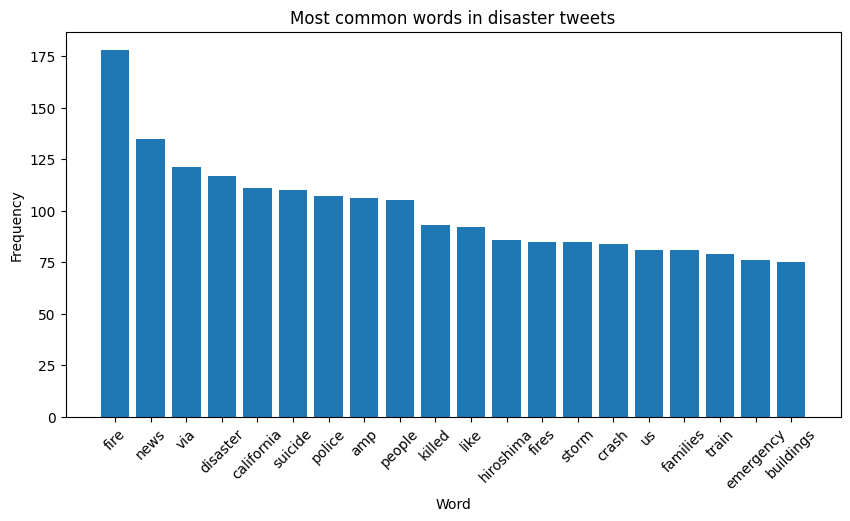

In [10]:
#plot the most common words in disaster tweets with a bar chart
disaster_word_freq_df = pd.DataFrame(disaster_word_freq.most_common(20), columns=['word', 'frequency'])
plt.figure(figsize=(10, 5))
plt.bar(disaster_word_freq_df['word'], disaster_word_freq_df['frequency'])
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most common words in disaster tweets')

Text(0.5, 1.0, 'Most common words in non-disaster tweets')

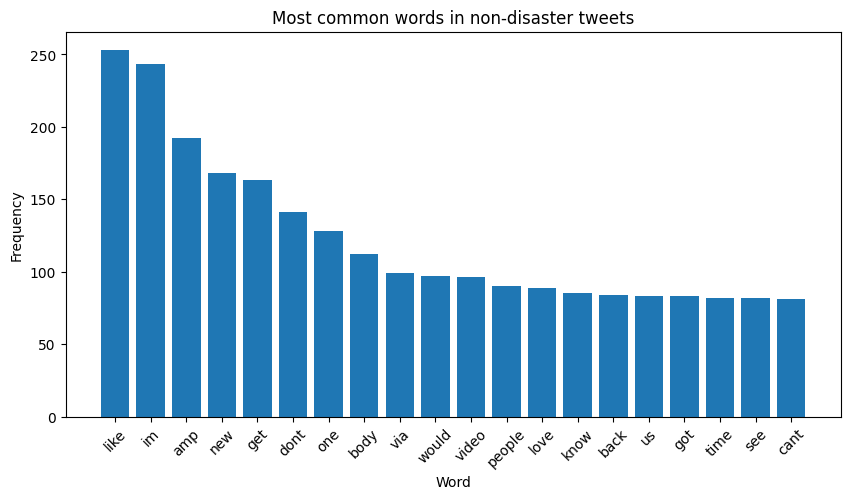

In [11]:
#plot the most common words in non-disaster tweets with a bar chart
non_disaster_word_freq_df = pd.DataFrame(non_disaster_word_freq.most_common(20), columns=['word', 'frequency'])
plt.figure(figsize=(10, 5))
plt.bar(non_disaster_word_freq_df['word'], non_disaster_word_freq_df['frequency'])
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most common words in non-disaster tweets')

Palabras como Fire, News y Distaster son palabras que aparecen con mucha frecuencia en el conjunto de desastres, pero no en el conjunto de no desastres, por lo que pueden ser de mucha utilidad para la clasificación. Palabas como amp, aparecen de manera significativa en ambos conjuntos, lo cual puede empeorar el rendimiento del modelo, por lo que debe considerarse eliminarlas.

Los trigramas y bigramas pueden ser muy útiles, ya que palabras como "Fire" o "Disaster" son muy comúnmente utilizadas para expresar algo completamente distinto a un desastre y el contexto en el cual estas son utilizadas puede aportar mucha información para poder realizar la clasificación.

In [12]:
#find the common words in both disaster and non-disaster tweets
disaster_common_words = {word for word, _ in disaster_word_freq.most_common(20)}
non_disaster_common_words = {word for word, _ in non_disaster_word_freq.most_common(20)}

common_words = disaster_common_words.intersection(non_disaster_common_words)

common_words


{'amp', 'like', 'people', 'us', 'via'}

In [13]:
#delete the common words from de clean_text column
def remove_common_words(text):
    return ' '.join([word for word in text.split() if word not in common_words])

df['clean_text'] = df['clean_text'].apply(remove_common_words)

df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",receive wildfires evacuation orders california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


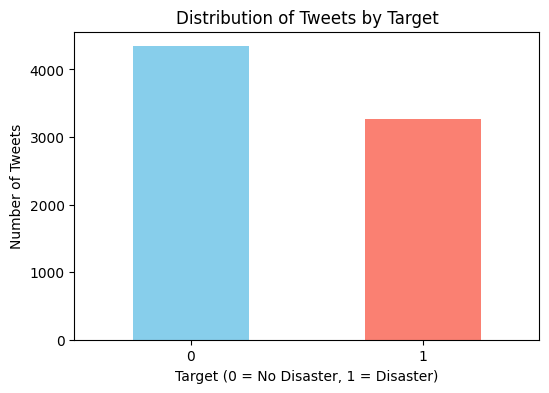

In [14]:
#Distribution of the target variable
target_distribution = df['target'].value_counts()

plt.figure(figsize=(6, 4))
target_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Tweets by Target')
plt.xlabel('Target (0 = No Disaster, 1 = Disaster)')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()


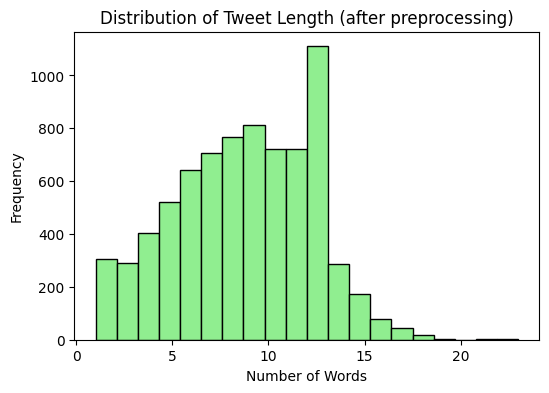

In [15]:
#Length of the tweets after preprocessing
df['tweet_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6, 4))
df['tweet_length'].plot(kind='hist', bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Tweet Length (after preprocessing)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


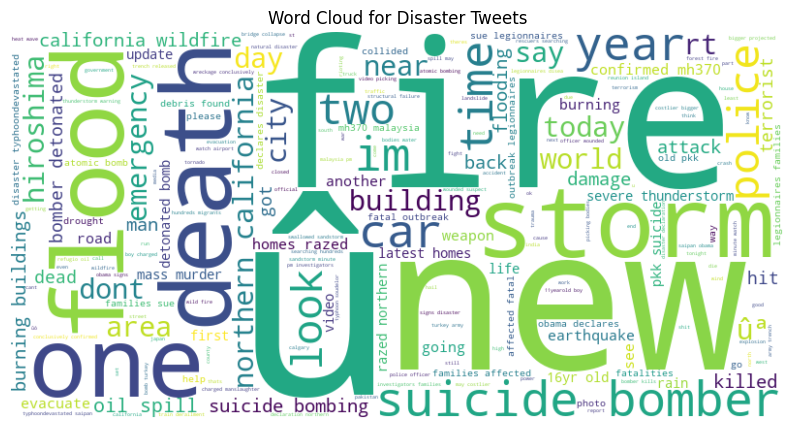

In [16]:
#Word cloud for disaster tweets
disaster_tweets = df[df['target'] == 1]['clean_text']
disaster_tweets = ' '.join(disaster_tweets)

""" words = disaster_tweets.split(" ")
most_common_words = Counter(words).most_common(10000)
print(most_common_words) """

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')
plt.show()

In [17]:
special_chars = ["\x89û", ""]

def remove_special_chars(text):
    for char in special_chars:
        text = text.replace(char, '')
    return text

df['clean_text'] = df['clean_text'].apply(remove_special_chars)

In [18]:
df.drop(['keyword', 'location'], axis=1, inplace=True)

# Modelado

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [20]:
seed = 2024

## Generación de n-gramas
Para el modelo probaremos tres tipos de n-gramas: unigramas, bigramas y trigramas. Esto, con el fin de evaluar cuál de estos tipos de n-gramas es el que mejor se ajusta al modelo y extrae el mejor contexto para poder realizar la clasificación.

In [21]:
unigram_vectorizer = CountVectorizer()
unigram_vectorizer.fit(df['clean_text'])
X_unigram = unigram_vectorizer.transform(df['clean_text'])

In [22]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
bigram_vectorizer.fit(df['clean_text'])
X_bigram = bigram_vectorizer.transform(df['clean_text'])

In [23]:
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit(df['clean_text'])
X_trigram = trigram_vectorizer.transform(df['clean_text'])

## Frecuencia de los n-gramas

In [24]:
def get_ngram_freqs(vectorizer, X):
    ngram_counts = X.sum(axis=0).A1  # Get the frequency of each n-gram
    ngram_freq = [(word, ngram_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]  # Map the text to the frequency
    return sorted(ngram_freq, key=lambda x: x[1], reverse=True)

In [25]:
unigram_freq = get_ngram_freqs(unigram_vectorizer, X_unigram)[:10]
bigram_freq = get_ngram_freqs(bigram_vectorizer, X_bigram)[:10]
trigram_freq = get_ngram_freqs(trigram_vectorizer, X_trigram)[:10]

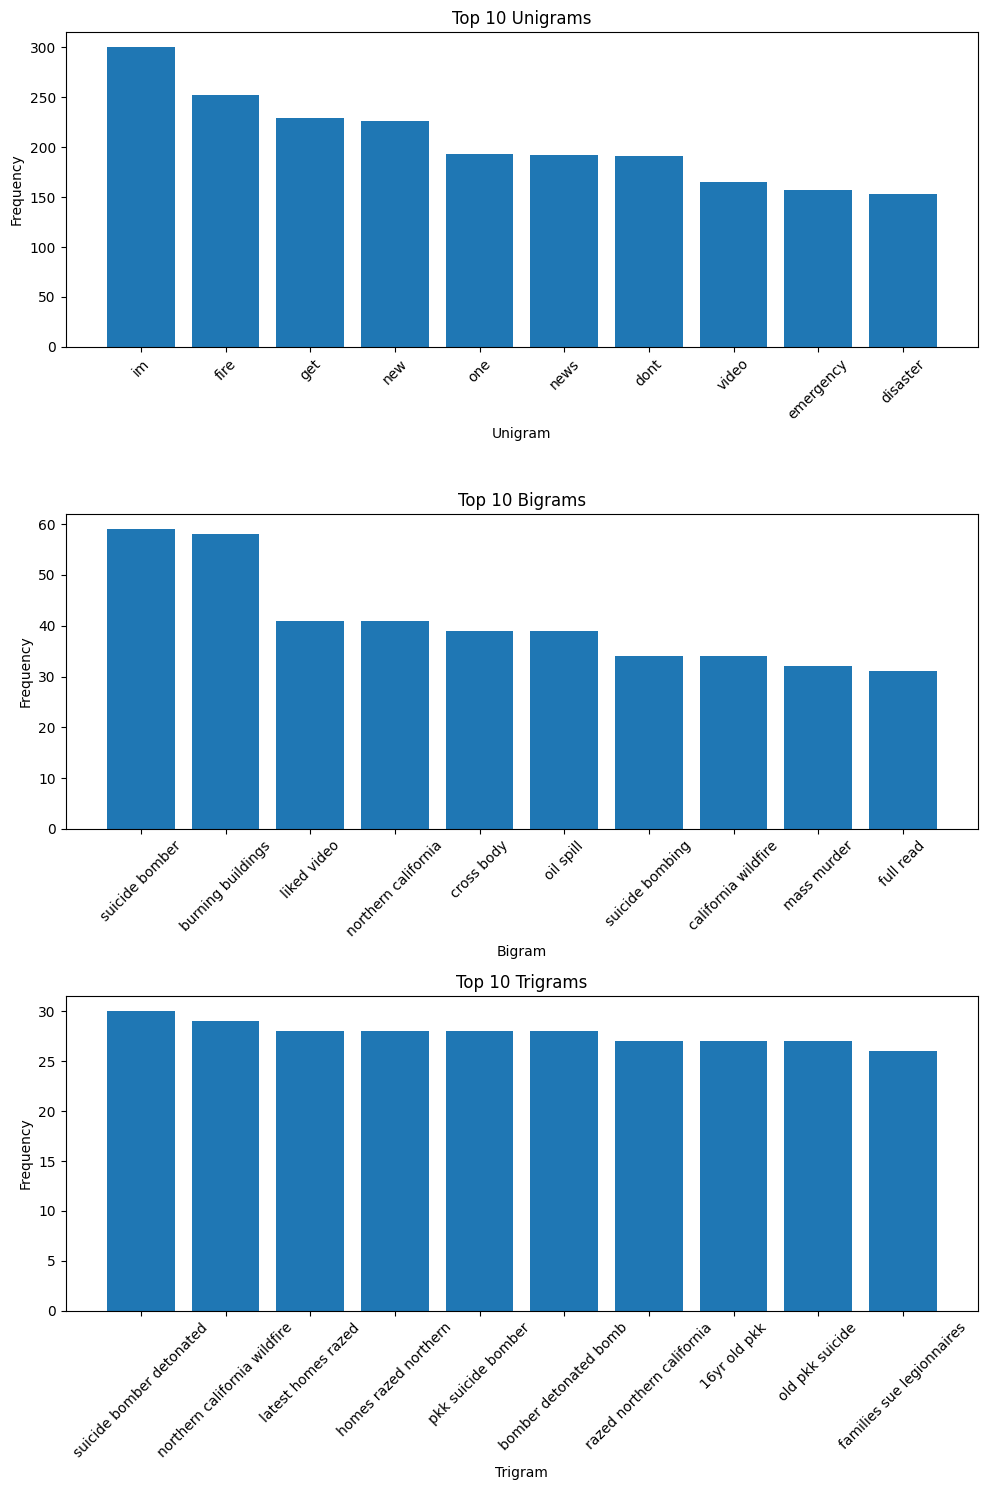

In [26]:
# Make a subplot for each n-gram
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot the unigram frequencies
unigram_freq_df = pd.DataFrame(unigram_freq, columns=['word', 'frequency'])
axs[0].bar(unigram_freq_df['word'], unigram_freq_df['frequency'])
axs[0].set_title('Top 10 Unigrams')
axs[0].set_xlabel('Unigram')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Plot the bigram frequencies
bigram_freq_df = pd.DataFrame(bigram_freq, columns=['word', 'frequency'])
axs[1].bar(bigram_freq_df['word'], bigram_freq_df['frequency'])
axs[1].set_title('Top 10 Bigrams')
axs[1].set_xlabel('Bigram')
axs[1].set_ylabel('Frequency')
axs[1].tick_params(axis='x', rotation=45)

# Plot the trigram frequencies
trigram_freq_df = pd.DataFrame(trigram_freq, columns=['word', 'frequency'])
axs[2].bar(trigram_freq_df['word'], trigram_freq_df['frequency'])
axs[2].set_title('Top 10 Trigrams')
axs[2].set_xlabel('Trigram')
axs[2].set_ylabel('Frequency')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Podemos observar que en los `bigramas` y `trigramas` aparecen expresiones con un contexto más definido (al menos para un humano). Hacen referencia a bombas, incendios forestales, entre otros tipos de desastres. Por otro lado, los `unigramas` no aportan mucho contexto, ya que las palabras que aparecen son muy comunes y no aportan información relevante para la clasificación.

## División del conjunto de datos

In [27]:
X = df['clean_text']
y = df['target']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [29]:
X_train_unigram = unigram_vectorizer.transform(X_train)
X_test_unigram = unigram_vectorizer.transform(X_test)

In [30]:
X_train_bigram = bigram_vectorizer.transform(X_train)
X_test_bigram = bigram_vectorizer.transform(X_test)

In [31]:
X_train_trigram = trigram_vectorizer.transform(X_train)
X_test_trigram = trigram_vectorizer.transform(X_test)

# Modelado
Para poder encontrar la mejor manera de realizar esta clasificación es importante realizar la iteración. En el caso del entrenamiento de modelos, esto implica encontrar el modelo que mejor se ajusta a los datos; en conjunto con el tuneo de hiperparámetros. Para este caso, se probarán tres modelos: Regresión Logística, Naive Bayes y SVM. Para cada uno de estos modelos se probarán los tres tipos de n-gramas y una búsqueda de hiperparámetros para encontrar el mejor modelo.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Regresión Logística

In [33]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

In [34]:
lr_unigram = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    param_grid, 
    cv=5
)
lr_unigram.fit(X_train_unigram, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [35]:
lr_bigram = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    param_grid, 
    cv=5
)
lr_bigram.fit(X_train_bigram, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [36]:
lr_trigram = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    param_grid, 
    cv=5
)
lr_trigram.fit(X_train_trigram, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [37]:
scores = {
    'Unigram': lr_unigram.score(X_test_unigram, y_test),
    'Bigram': lr_bigram.score(X_test_bigram, y_test),
    'Trigram': lr_trigram.score(X_test_trigram, y_test)
}

sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

for i, (ngram, score) in enumerate(sorted_scores.items(), 1):
    print(f'{i}. {ngram}: {score}')

1. Unigram: 0.8115561391989494
2. Bigram: 0.7458962573867367
3. Trigram: 0.6946815495732108


## Naive Bayes

In [38]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

In [39]:
nb_unigram = GridSearchCV(
    MultinomialNB(), 
    param_grid, 
    cv=5
)
nb_unigram.fit(X_train_unigram, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [40]:
nb_bigram = GridSearchCV(
    MultinomialNB(), 
    param_grid, 
    cv=5
)
nb_bigram.fit(X_train_bigram, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [41]:
nb_trigram = GridSearchCV(
    MultinomialNB(), 
    param_grid, 
    cv=5
)
nb_trigram.fit(X_train_trigram, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [42]:
scores = {
    'Unigram': nb_unigram.score(X_test_unigram, y_test),
    'Bigram': nb_bigram.score(X_test_bigram, y_test),
    'Trigram': nb_trigram.score(X_test_trigram, y_test)
}

sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

for i, (ngram, score) in enumerate(sorted_scores.items(), 1):
    print(f'{i}. {ngram}: {score}')

1. Unigram: 0.8082731451083388
2. Bigram: 0.7564018384766907
3. Trigram: 0.6966513460275772


## SVMs

In [43]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

In [44]:
svm_unigram = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=5
)
svm_unigram.fit(X_train_unigram, y_train)

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [45]:
svm_bigram = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=5
)
svm_bigram.fit(X_train_bigram, y_train)

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [46]:
svm_trigram = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=5
)
svm_trigram.fit(X_train_trigram, y_train)

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [47]:
scores = {
    'Unigram': svm_unigram.score(X_test_unigram, y_test),
    'Bigram': svm_bigram.score(X_test_bigram, y_test),
    'Trigram': svm_trigram.score(X_test_trigram, y_test)
}

sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

for i, (ngram, score) in enumerate(sorted_scores.items(), 1):
    print(f'{i}. {ngram}: {score}')

1. Unigram: 0.81483913328956
2. Bigram: 0.7426132632961261
3. Trigram: 0.6776099803020355


# Selección del mejor modelo
Al contrario de lo mencionado "a simple vista" con los trigramas, estos fueron los que peor desempeño tuvieron en los tres modelos. El `n-grama` que más destaco fue el unigrama.

In [48]:
unigram_scores = {
    'Logistic Regression': lr_unigram.score(X_test_unigram, y_test),
    'Naive Bayes': nb_unigram.score(X_test_unigram, y_test),
    'SVM': svm_unigram.score(X_test_unigram, y_test)
}

sorted_unigram_scores = {k: v for k, v in sorted(unigram_scores.items(), key=lambda item: item[1], reverse=True)}

for i, (model, score) in enumerate(sorted_unigram_scores.items(), 1):
    print(f'{i}. {model}: {score}')

1. SVM: 0.81483913328956
2. Logistic Regression: 0.8115561391989494
3. Naive Bayes: 0.8082731451083388


En base al desempeño obtenido, el modelo seleccionado es el de **SVM con unigramas**.

# Función para predecir
Se realiza una manera de poder ingresar un nuevo tweet y poder predecir si este es un desastre o no.

In [49]:
def predict_tweet(tweet):
    tweet = preprocess_text(tweet)
    tweet = remove_special_chars(tweet)
    tweet = unigram_vectorizer.transform([tweet])
    return "Disaster" if svm_unigram.predict(tweet)[0] == 1 else "No Disaster"

In [54]:
test_tweets = [
    "There is a fire in the forest",
    "It's to hot! I feel like I'm on fire",
    "There was an explosion in the city",
    "My house flooded due to the rain",
    "I'm so hungry, I could eat a horse"
]

In [55]:
for tweet in test_tweets:
    print(f'Tweet: {tweet}')
    print(f'Prediction: {predict_tweet(tweet)}')
    print()

Tweet: There is a fire in the forest
Prediction: Disaster

Tweet: It's to hot! I feel like I'm on fire
Prediction: No Disaster

Tweet: There was an explosion in the city
Prediction: Disaster

Tweet: My house flooded due to the rain
Prediction: Disaster

Tweet: I'm so hungry, I could eat a horse
Prediction: No Disaster



# Discusión

Respecto a la limpieza de datos, todos los textos fueron convertidos a minúsculas para evitar confusión entre palabras iguales. También se eliminaron urls, ya que estas no aportan información importante que pueda ser analizada por medio del lenguaje natural.

Fueron eliminados caracteres especiales, como "@", "#" y signos de puntuación. Respecto a las menciones, fueron removidas totalmente, ya que no aportan información útil. Respecto a los hashtags, estos aportan mucha información, muchas veces las ideas principales del tweet, por lo que no fueron eliminados.

Al igual que los hashtags, el número 911 puede aportar mucha información respecto a si un tweet refiere a un desastre o no, ya que, en Estados Unidos, es el número utilizado para las emergencias, por lo que se decidió conservar únicamente ese numero.

Luego de analizar las palabras más comunes tanto en tweets de desastres como en los que no son desastres, se puede observar que existen palabras que aparecen entre las más comunes para ambos. Debido a esto se recolectaron dichas palabras repetidas dentro de las 20 más comunes y se eliminaron de los tweets. Esto se realizó con el fin de proporcionar la menor ambigüedad posible a la hora de entrenar nuestro modelo y evitar que este pueda confundir a la hora de realizar una clasificación.

En cuanto a lo que es el modelado se realizaron diferentes pruebas para poder encontrar la mejor combinación de elementos para poder clasificar de la mejor manera. Todos los modelos pasaron por un proceso similar, en el cual se probaban diferentes n-gramas y se realizaba una búsqueda de hiperparámetros para poder encontrar el mejor modelo.

Los n-gramas fueron una parte interesante de la práctica, pues, para el ojo humano, era más fácil poder hacer una predicción con el contexto de un trigrama (3 palabras). Sin embargo, al entrenar los modelos, estos no tuvieron un buen desempeño. Los unigramas, que son las palabras individuales, fueron los que mejor desempeño tuvieron en los tres modelos y con una diferencia considerable.

En cuanto a los modelos, al estar utilizando unigramas, los tres obtuvieron un desempeño similar (alrededor del 80%). En ninguno de los casos los recursos computacionales fueron un problema, ya que el tiempo de entrenamiento fue similar para los tres modelos; sin importar el n-grama que se estuviera utilizando. Con estas conclusiones, se termino utilizandoe l modelos de Máquinas de Soporte Vectorial (SVM) con unigramas, ya que fue el que mejor desempeño tuvo en el conjunto de datos.

Gracias a que en el proceso de limpieza se utilizaron funciones para replicar en diferentes entradas del conjunto de datos, podemos utilizar el mismo preprocesamiento para nuevos tweets y poder realizar una predicción con el modelo seleccionado. En el caso de los tweets de prueba (escritos por nosotros), el modelo tuvo un desempeño perfecto, clasificando correctamente cada uno de los tweets.